In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [10]:
df = pd.read_csv('drive/MyDrive/Diplomski/cyberbullying_tweets.csv')
X = df['tweet_text'].values
y = df['cyberbullying_type'].values

<Axes: >

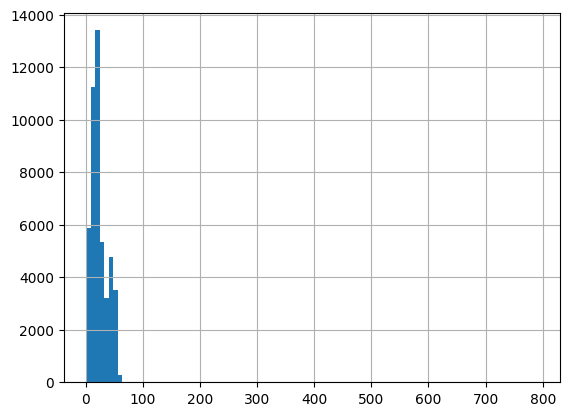

In [13]:
seq_len = [len(i.split()) for i in X]

pd.Series(seq_len).hist(bins = 100)

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=123)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [17]:
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [18]:
max_seq_len = 50

In [19]:
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [22]:
for name, param in bert.named_parameters():
    # unfreezing only query.bias and second MLP layer
    if 'query.bias' in name or 'layer.2' in name:
        print(name)
    else:
        param.requires_grad = False

encoder.layer.0.attention.self.query.bias
encoder.layer.1.attention.self.query.bias
encoder.layer.2.attention.self.query.weight
encoder.layer.2.attention.self.query.bias
encoder.layer.2.attention.self.key.weight
encoder.layer.2.attention.self.key.bias
encoder.layer.2.attention.self.value.weight
encoder.layer.2.attention.self.value.bias
encoder.layer.2.attention.output.dense.weight
encoder.layer.2.attention.output.dense.bias
encoder.layer.2.attention.output.LayerNorm.weight
encoder.layer.2.attention.output.LayerNorm.bias
encoder.layer.2.intermediate.dense.weight
encoder.layer.2.intermediate.dense.bias
encoder.layer.2.output.dense.weight
encoder.layer.2.output.dense.bias
encoder.layer.2.output.LayerNorm.weight
encoder.layer.2.output.LayerNorm.bias
encoder.layer.3.attention.self.query.bias
encoder.layer.4.attention.self.query.bias
encoder.layer.5.attention.self.query.bias
encoder.layer.6.attention.self.query.bias
encoder.layer.7.attention.self.query.bias
encoder.layer.8.attention.self.que

In [23]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      self.dropout = nn.Dropout(0.1)

      self.relu =  nn.ReLU()

      self.fc1 = nn.Linear(768,512)

      self.fc2 = nn.Linear(512,6)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      x = self.fc2(x)

      x = self.softmax(x)

      return x

In [33]:
model = BERT_Arch(bert)
model = model.to(device)
#following lines only if training is stared on previous model
path = '/content/drive/MyDrive/Diplomski/saved_weights_current.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [34]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-5)
# 5e-5 starting lr, optinal: 1e-5, 2e-5, 3e-5 in later training stages

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

print(class_wts)

[0.99838507 0.99339404 0.98390805 0.99180036 1.03266518 1.00125967]


In [36]:
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights)

epochs = 5

In [37]:
#model training
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  total_preds=[]

  for step,batch in enumerate(train_dataloader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    model.zero_grad()

    preds = model(sent_id, mask)

    loss = cross_entropy(preds, labels)

    total_loss = total_loss + loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    preds=preds.detach().cpu().numpy()

    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)

  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [38]:
# function for evaluating the model

import matplotlib.pyplot as plt

def calculate_accuracy(preds, labels):
    predicted_classes = np.argmax(preds, axis=1)
    labels_cpu = labels.cpu().numpy()
    correct_predictions = np.sum(predicted_classes == labels_cpu).item()

    accuracy = correct_predictions / len(labels)

    return accuracy

def plot_accuracy(accuracy_list):
    plt.plot(accuracy_list, label='Accuracy')
    plt.title('Validation Accuracy Over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def evaluate():

  print("\nEvaluating...")

  model.eval()

  total_loss, total_accuracy = 0, 0

  total_preds = []
  accuracy_list = []


  for step,batch in enumerate(val_dataloader):

    if step % 50 == 0 and not step == 0:

      # elapsed = format_time(time.time() - t0)

      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    with torch.no_grad():

      preds = model(sent_id, mask)

      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

      accuracy = calculate_accuracy(preds, labels)
      total_accuracy += accuracy
      accuracy_list.append(accuracy)

  avg_loss = total_loss / len(val_dataloader)
  avg_accuracy = total_accuracy / len(val_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)

  # plot_accuracy(accuracy_list)

  return avg_loss, total_preds, avg_accuracy



 Epoch 1 / 5
  Batch    50  of  1,044.
  Batch   100  of  1,044.
  Batch   150  of  1,044.
  Batch   200  of  1,044.
  Batch   250  of  1,044.
  Batch   300  of  1,044.
  Batch   350  of  1,044.
  Batch   400  of  1,044.
  Batch   450  of  1,044.
  Batch   500  of  1,044.
  Batch   550  of  1,044.
  Batch   600  of  1,044.
  Batch   650  of  1,044.
  Batch   700  of  1,044.
  Batch   750  of  1,044.
  Batch   800  of  1,044.
  Batch   850  of  1,044.
  Batch   900  of  1,044.
  Batch   950  of  1,044.
  Batch 1,000  of  1,044.

Evaluating...
  Batch    50  of    300.
  Batch   100  of    300.
  Batch   150  of    300.
  Batch   200  of    300.
  Batch   250  of    300.


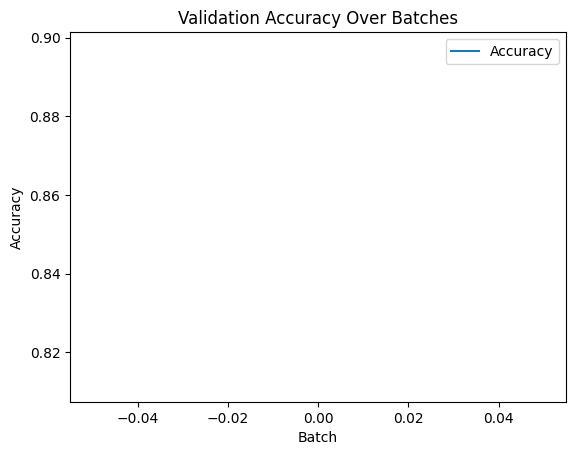

AVG ACCURACY:  0.8543981481481482

Training Loss: 0.192
Validation Loss: 0.451

 Epoch 2 / 5
  Batch    50  of  1,044.
  Batch   100  of  1,044.
  Batch   150  of  1,044.
  Batch   200  of  1,044.
  Batch   250  of  1,044.
  Batch   300  of  1,044.
  Batch   350  of  1,044.
  Batch   400  of  1,044.
  Batch   450  of  1,044.
  Batch   500  of  1,044.
  Batch   550  of  1,044.
  Batch   600  of  1,044.
  Batch   650  of  1,044.
  Batch   700  of  1,044.
  Batch   750  of  1,044.
  Batch   800  of  1,044.
  Batch   850  of  1,044.
  Batch   900  of  1,044.
  Batch   950  of  1,044.
  Batch 1,000  of  1,044.

Evaluating...
  Batch    50  of    300.
  Batch   100  of    300.
  Batch   150  of    300.
  Batch   200  of    300.
  Batch   250  of    300.


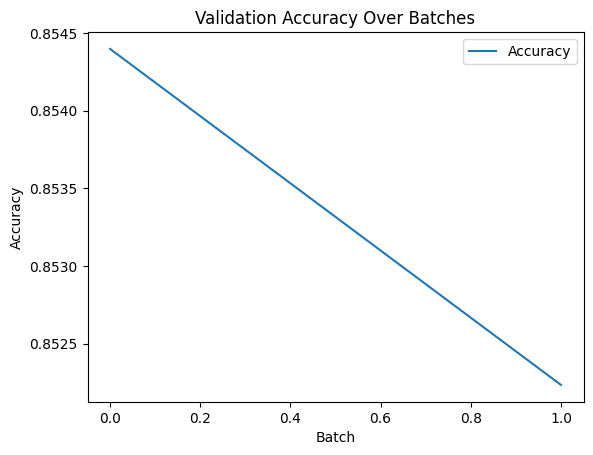

AVG ACCURACY:  0.8522337962962963

Training Loss: 0.180
Validation Loss: 0.460

 Epoch 3 / 5
  Batch    50  of  1,044.
  Batch   100  of  1,044.
  Batch   150  of  1,044.
  Batch   200  of  1,044.
  Batch   250  of  1,044.
  Batch   300  of  1,044.
  Batch   350  of  1,044.
  Batch   400  of  1,044.
  Batch   450  of  1,044.
  Batch   500  of  1,044.
  Batch   550  of  1,044.
  Batch   600  of  1,044.
  Batch   650  of  1,044.
  Batch   700  of  1,044.
  Batch   750  of  1,044.
  Batch   800  of  1,044.
  Batch   850  of  1,044.
  Batch   900  of  1,044.
  Batch   950  of  1,044.
  Batch 1,000  of  1,044.

Evaluating...
  Batch    50  of    300.
  Batch   100  of    300.
  Batch   150  of    300.
  Batch   200  of    300.
  Batch   250  of    300.


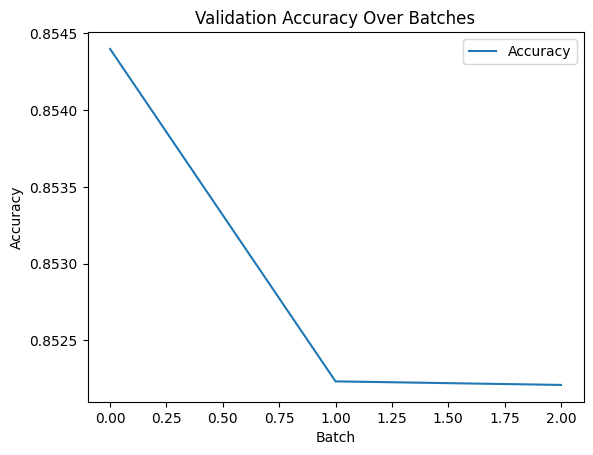

AVG ACCURACY:  0.8522106481481482

Training Loss: 0.171
Validation Loss: 0.486

 Epoch 4 / 5
  Batch    50  of  1,044.
  Batch   100  of  1,044.
  Batch   150  of  1,044.
  Batch   200  of  1,044.
  Batch   250  of  1,044.
  Batch   300  of  1,044.
  Batch   350  of  1,044.
  Batch   400  of  1,044.
  Batch   450  of  1,044.
  Batch   500  of  1,044.
  Batch   550  of  1,044.
  Batch   600  of  1,044.
  Batch   650  of  1,044.
  Batch   700  of  1,044.
  Batch   750  of  1,044.
  Batch   800  of  1,044.
  Batch   850  of  1,044.
  Batch   900  of  1,044.
  Batch   950  of  1,044.
  Batch 1,000  of  1,044.

Evaluating...
  Batch    50  of    300.
  Batch   100  of    300.
  Batch   150  of    300.
  Batch   200  of    300.
  Batch   250  of    300.


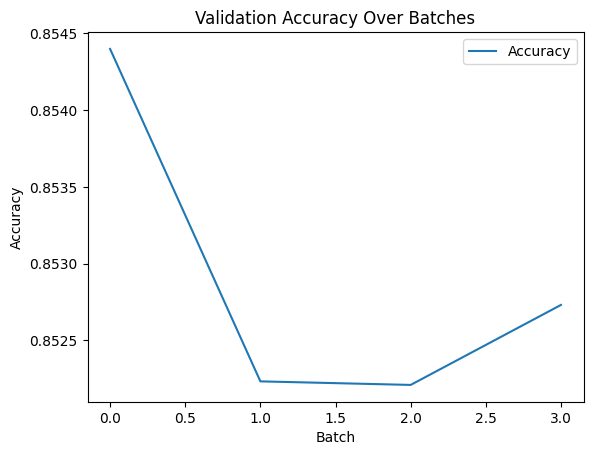

AVG ACCURACY:  0.8527314814814815

Training Loss: 0.165
Validation Loss: 0.496

 Epoch 5 / 5
  Batch    50  of  1,044.
  Batch   100  of  1,044.
  Batch   150  of  1,044.
  Batch   200  of  1,044.
  Batch   250  of  1,044.
  Batch   300  of  1,044.
  Batch   350  of  1,044.
  Batch   400  of  1,044.
  Batch   450  of  1,044.
  Batch   500  of  1,044.
  Batch   550  of  1,044.
  Batch   600  of  1,044.
  Batch   650  of  1,044.
  Batch   700  of  1,044.
  Batch   750  of  1,044.
  Batch   800  of  1,044.
  Batch   850  of  1,044.
  Batch   900  of  1,044.
  Batch   950  of  1,044.
  Batch 1,000  of  1,044.

Evaluating...
  Batch    50  of    300.
  Batch   100  of    300.
  Batch   150  of    300.
  Batch   200  of    300.
  Batch   250  of    300.


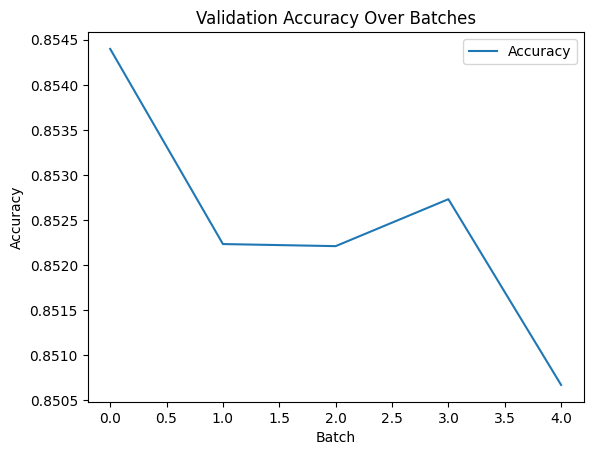

AVG ACCURACY:  0.8506712962962962

Training Loss: 0.159
Validation Loss: 0.507


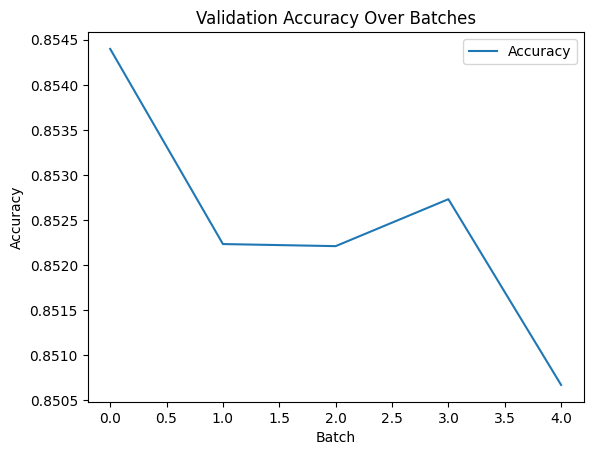

In [39]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]
all_preds = []
accuracy_list = []

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()

    valid_loss, preds, avg_accuracy  = evaluate()
    all_preds.append(preds)
    accuracy_list.append(avg_accuracy)
    plot_accuracy(accuracy_list)
    print("AVG ACCURACY: ", avg_accuracy)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Diplomski/saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

plot_accuracy(accuracy_list)

In [40]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Diplomski/saved_weights_current.pt')

In [42]:
model = BERT_Arch(bert)
model = model.to(device)
path = '/content/drive/MyDrive/Diplomski/saved_weights.pt'
model.load_state_dict(torch.load(path, map_location=torch.device('cuda')))

<All keys matched successfully>

In [43]:
tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

In [45]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [47]:
preds = np.argmax(preds, axis = 1)

In [49]:
print(classification_report(y_test, preds))
print('\n', label_encoder.classes_)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       812
           1       0.98      0.98      0.98       781
           2       0.89      0.89      0.89       761
           3       0.67      0.61      0.64       771
           4       0.70      0.74      0.72       825
           5       0.92      0.96      0.94       772

    accuracy                           0.86      4722
   macro avg       0.86      0.86      0.86      4722
weighted avg       0.86      0.86      0.86      4722


 ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'
 'religion']
